# **Questão 2 do Projeto de Aprendizagem de Máquina**

Considere novamente os dados "banknote authentication Data Set".

a) Use validação cruzada estratificada “10-folds” para avaliar e comparar os classificadores combinados descritos abaixo. Quando necessario, retire do conjunto de aprendizagem, um conjunto de validação (20%) para fazer ajuste de parametros e depois treine o modelo novamente com os conjuntos aprendizagem + validação. Use amostragem estratificada;

b) Obtenha uma estimativa pontual e um intervalo de confiança para cada métrica de avaliação do classificador (Taxa de erro, precisão, cobertura, F-measure);

c) Usar o Friedman test (teste não parametrico) para comparar os classificadores;

## Importando bibliotecas e carregando os dados:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate #Este usa stratified KFold quando o parâmetro cv é int (nosso caso).
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm 
import math
from scipy import mean
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import multivariate_normal
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin

In [3]:
cols = ['x1','x2', 'x3', 'x4', 'class']
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt", header=None, names=cols)
                         

In [4]:
df.head()

,x1,x2,x3,x4,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


## Pré-processamento

In [5]:
# Normalização usando o MinMax
scaler = MinMaxScaler(feature_range=(0.00001, 1.00001))
df[['x1','x2', 'x3', 'x4']] = scaler.fit_transform(df[['x1','x2', 'x3', 'x4']])

# Imputando média em lugar de valores faltantes (se houver):
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df[['x1','x2','x3','x4']] = imp_mean.fit_transform(df[['x1','x2','x3','x4']])

### Separando X e y:

In [6]:
X = df[df.columns[:-1]]
y = df[df.columns[[-1]]]

##Analise Exploratoria dos Dados

In [7]:
# Verificar tipos de dados
df.dtypes

x1       float64
x2       float64
x3       float64
x4       float64
class      int64
dtype: object

In [8]:
# Verificar valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      1372 non-null   float64
 1   x2      1372 non-null   float64
 2   x3      1372 non-null   float64
 3   x4      1372 non-null   float64
 4   class   1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [9]:
pd.options.mode.use_inf_as_na = True
df.isnull().sum()

x1       0
x2       0
x3       0
x4       0
class    0
dtype: int64

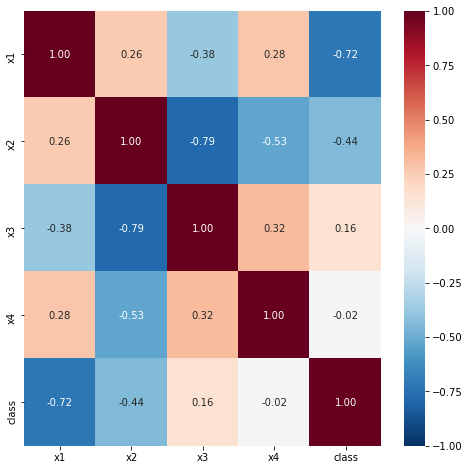

In [10]:
# Verificar correlaçao entre cada variavel dentro de um Mapa de Calor:
from seaborn import heatmap
fig, ax = plt.subplots(figsize=(8, 8))
ax = heatmap(
    df.corr(),
    fmt=".2f",
    annot=True,
    ax=ax,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
)

In [11]:
#Correlação dos dados-Matriz de Dispersão
#from pandas.plotting import scatter_matrix

#attributes=["x1", "x2", "x3", "x4"]

#scatter_matrix(df[attributes], figsize=(12,8))
#verificar por meiod e pearson correlação entre duas colunas
#X.x1.corr(X.x4)

In [12]:
def calculate_metrics(cv_results):
  test_error_rate = np.ones(10)-cv_results['test_accuracy']  # error_rate = 1 - accuracy
  error_mean = np.mean(test_error_rate)
  error_std = np.std(test_error_rate)
  precision_mean = np.mean(cv_results['test_precision'])
  precision_std = np.std(cv_results['test_precision'])
  recall_mean = np.mean(cv_results['test_recall'])
  recall_std = np.std(cv_results['test_recall'])
  f1_mean = np.mean(cv_results['test_f1'])
  f1_std = np.std(cv_results['test_f1'])

  z_critical = norm.ppf(0.95) #valor crítico Z para intervalo de confiança de 95%
  pop_size = X.shape[0]

  # Dicionário para armazenar as métricas: 
  results = {'error_rate':None, 'precision':None, 'recall':None, 'f1':None}

  error_margin = z_critical * (error_std/sqrt(pop_size))
  error_conf_interv = (error_mean - error_margin, error_mean + error_margin)
  results['error_rate'] = {'mean':error_mean, 'conf_interv':error_conf_interv}

  precision_margin = z_critical * (precision_std/sqrt(pop_size))
  precision_conf_interv = (precision_mean - precision_margin, precision_mean + precision_margin)
  results['precision'] = {'mean':precision_mean, 'conf_interv':precision_conf_interv}
  
  recall_margin = z_critical * (recall_std/sqrt(pop_size))
  recall_conf_interv = (recall_mean - recall_margin, recall_mean + recall_margin)
  results['recall'] = {'mean':recall_mean, 'conf_interv':recall_conf_interv}

  f1_margin = z_critical * (f1_std/sqrt(pop_size))
  f1_conf_interv = (f1_mean - f1_margin, f1_mean + f1_margin)
  results['f1'] = {'mean':f1_mean, 'conf_interv':f1_conf_interv}

  return results

## Item i) Classificador bayesiano gaussiano


In [13]:
class BayesClassifier(BaseEstimator, ClassifierMixin):
    mu = None
    cov = None
    n_classes = None
    
#calculo da probabilidade prior
    def _calculate_prior(self, c):
    #(número de exemplos da classe dividido pelo número total de exemplos. 
    #Amostras da classe == c / numero total de amostras)"""
        frequency = np.mean(self.y == c) ######Porque a média? porque divide pelo numero total de exemplos
        return frequency 

    def pred(self,x):
        posterior = np.zeros(self.n_classes)        
        for i in range(self.n_classes):
            #função de densidade=normal multivariada     
            mnormal = multivariate_normal(mean=self.mu[i], cov=self.cov[i])  #usa a normal multivariada        
            prior = self._calculate_prior(i)           
            posterior[i] = prior*mnormal.pdf(x) #densidade vezes a prior, para estimar a posterior
            sumatory = 0.
            for j in range(self.n_classes):
                mnormal = multivariate_normal(mean=self.mu[j], cov=self.cov[j])
                sumatory += prior*mnormal.pdf(x)
            posterior[i] = posterior[i]/sumatory
        return np.argmax(posterior)  #retorna a probabilidade posterior máxima

#calcula o vetor de médias e a matriz de covariancia para cada classe          
    def fit(self, X,y):
        self.n_classes = len(np.unique(y))
        if not isinstance(X, np.ndarray): self.X, self.y = X.to_numpy(), y
        else: self.X, self.y = X, y
        self.mu = [] #corresponde a variavel do vetor de médias
        self.cov = [] #corresponde a variavel da matriz sigma diagonal      

        for i in range(self.n_classes):
            Xc = self.X[self.y==i]#separando os valores para cada classe
            mu_c = np.mean(Xc, axis=0) #calcula o vetor médio dos valores para cada classe
            self.mu.append(mu_c)
            cov_c = np.zeros((X.shape[1], X.shape[1]))
            for j in range(Xc.shape[1]):
                var = np.var(Xc[:,[j]].reshape((1,Xc.shape[0])))
                cov_c[j][j] = var          
                cov = cov_c
                self.cov.append(cov_c)
            self.cov.append(cov_c)
        self.mu = np.asarray(self.mu)
        self.cov = np.asarray(self.cov)
    def predict(self, X):
        if not isinstance(X, np.ndarray): self.X = X.to_numpy()
        else: self.X = X
        y_pred = [self.pred(x) for x in self.X]
        return np.array(y_pred)

In [14]:
gbc = BayesClassifier()
cv_results_gbc = cross_validate(gbc, X, y.values.ravel(), cv = 10, scoring=('accuracy', 'precision', 'recall', 'f1'))
metrics_gbc = calculate_metrics(cv_results_gbc)
metrics_gbc


{'error_rate': {'mean': 0.1618216439225643,
  'conf_interv': (0.16079489639895392, 0.16284839144617466)},
 'precision': {'mean': 0.8205730125199941,
  'conf_interv': (0.8194209594018245, 0.8217250656381638)},
 'recall': {'mean': 0.8147540983606557,
  'conf_interv': (0.8129109963162171, 0.8165972004050943)},
 'f1': {'mean': 0.8171105205253039,
  'conf_interv': (0.81587786929735, 0.8183431717532578)}}

## Item ii) Classificador bayesiano baseados em k-vizinhos:

Treine um classificador bayesiano baseado em k-vizinhos. Normalize os dados e use a distância Euclidiana para definir a vizinhança. Use conjunto de validação para fixar o o número de vizinhos k.

In [15]:
#Divisão do conjunto em treino e teste
train_val_x, test_x, train_val_y, test_y = train_test_split(X,y)
#20% para validação da parte do conjunto de treino
train_x, val_x, train_y, val_y = train_test_split(train_val_x, train_val_y, test_size=0.2)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(weights='distance'),
             param_grid={'metric': ['euclidean'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})
{'metric': 'euclidean', 'n_neighbors': 5}


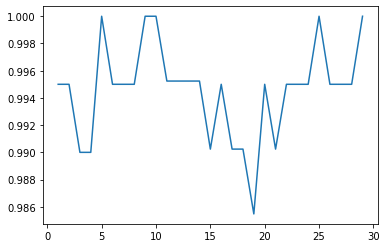

In [16]:
knn = KNeighborsClassifier(weights='distance')
#lista para escolher o melhor k vizinho(entre 1 e 30)
k_list=np.arange(1,30)
#k_list = list(range(7,30))
metric = ['euclidean']
param_grid= dict(n_neighbors=k_list, metric=metric)
#GridSearchCV, permite encontrar o melhor k da lista
classifier = GridSearchCV(knn, param_grid, cv=10)
print(classifier)
#ajustando o hiperparametro no conjunto de validacao
classifier.fit(val_x, val_y.values.ravel())
#print(classifier)
#print(classifier.best_estimator_)
#encontrando o melhor k
print(classifier.best_params_)
best_n = classifier.best_params_['n_neighbors']
plt.plot(classifier.cv_results_['param_n_neighbors'].data, classifier.cv_results_['mean_test_score'])

In [17]:
knn = KNeighborsClassifier(n_neighbors=best_n, weights='distance', metric='euclidean')
cv_results_knn = cross_validate(knn, X, y.values.ravel(), cv = 10, scoring=('accuracy', 'precision', 'recall', 'f1'))
metrics_knn = calculate_metrics(cv_results_knn)
metrics_knn

{'error_rate': {'mean': 0.0014598540145985383,
  'conf_interv': (0.0013301989083862279, 0.0015895091208108488)},
 'precision': {'mean': 0.9967741935483871,
  'conf_interv': (0.9964876975878858, 0.9970606895088885)},
 'recall': {'mean': 1.0, 'conf_interv': (1.0, 1.0)},
 'f1': {'mean': 0.9983739837398374,
  'conf_interv': (0.9982295711418612, 0.9985183963378137)}}

In [18]:
cv_results_knn['test_accuracy']

array([1.        , 1.        , 1.        , 1.        , 0.99270073,
       1.        , 1.        , 1.        , 1.        , 0.99270073])

## Item iii) Classificador bayesiano baseado em janela de Parzen:

Treine um classificador bayesiano baseado em janela de Parzen. Use a função de kernel multivariada produto com um mesmo h para todas as dimensões e a função de kernel Gaussiana unidimensional. Use conjunto de validação para fixar o parâmetro h.

In [19]:
#NBParzem é a classe que conterá a implementação do classificador baysesiano baseado em janela de Parzem
#Baseado nesse link:https://github.com/python-engineer/MLfromscratch/blob/master/mlfromscratch/naivebayes.py

class NBParzem(BaseEstimator, ClassifierMixin):
#h(tamanho da janela), hiperparametro    
    def __init__(self, h=0.1):
        self.h = h
    def get_params(self, deep=True):
        return {"h": self.h}
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X, y):
        n_samples, n_features = X.shape #numero de amostra e de atributos
        self._classes = np.unique(y)
        self.X, self.y = X.to_numpy(), y
        n_classes = len(self._classes)
        self.n = n_samples

        # calcula a media, variancia e a prior de cada classe
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors =  np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = self.X[self.y==c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0)
            self._priors[idx] = X_c.shape[0] / float(n_samples)

    def pred(self, x):
        posteriors = []
        #calcula media, variancia e a probabilidade prior
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            posterior = np.sum(np.log(self.multivariateproduct(idx, x)))
            posterior = prior + posterior
            posteriors.append(posterior)           
        # retorna a classe com maior probabilidade posteriori
        return self._classes[np.argmax(posteriors)]
    
    #Estimador kernel - slide 17 da aula 26/11 que é a função kernel multivariada produto            
    def multivariateproduct(self, class_idx, x):
    #self.univariate_normal(class_idx, x) corresponde a função escolhida que é a normal univariada para densidade
    #considerou-se a mesma função para todos os atributos      
         p = (1/self.n) * (1/self.h) *  np.sum(np.prod(self.univariate_normal(class_idx, x)))
         return p    
    
    #função de densidade em que calcula a média e variancia, corresponde ao naive bayes gaussiano. Seja uma distribuição gaussiana P(x). Os parâmetros média (µ) e a variância
    #(σ2) especificam completamente esta distribuição normal unidimensional.
    #regra no slide 12 da univariada
    def univariate_normal(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(- (x-mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator
    
    #realiza a predição para amostras de teste
    def predict(self, X):
        if not isinstance(X, np.ndarray): self.X = X.to_numpy()
        else: self.X = X
        y_pred = [self.pred(x) for x in self.X]
        return np.array(y_pred)


In [20]:
nbparzem = NBParzem()
train_val_x, test_x, train_val_y, test_y = train_test_split(X,y)
#20% para validação da parte do conjunto de treino
train_x, val_x, train_y, val_y = train_test_split(train_val_x, train_val_y, test_size=0.2)
param_grid = [{'bandwidth': [0.1, 0.2, 0.3, 0.6, 10, 20, 30]}]
#GridSearchCV, permite encontrar o melhor h da lista
classifier = GridSearchCV(nbparzem, param_grid, cv=10)
#ajustando o hiperparametro no conjunto de validacao
classifier.fit(val_x, val_y.values.ravel())
#print(classifier.best_estimator_)
#encontrando o melhor h
print(classifier.best_params_)
best_bandwidth = classifier.best_params_['bandwidth']

#plot

results = classifier.cv_results_
#print(results)
#plt.plot(classifier.cv_results_['param_bandwidth'].data, classifier.cv_results_['mean_test_score'])


{'bandwidth': 0.1}


In [21]:
nbparzem = NBParzem(h=best_bandwidth)
cv_results_nbparzem = cross_validate(nbparzem, X, y.values.ravel(), cv = 10, scoring=('accuracy', 'precision', 'recall', 'f1'))
metrics_nbparzem = calculate_metrics(cv_results_nbparzem)
metrics_nbparzem

{'error_rate': {'mean': 0.15892309319792658,
  'conf_interv': (0.1572290477723239, 0.16061713862352925)},
 'precision': {'mean': 0.8408442589082463,
  'conf_interv': (0.839437241622732, 0.8422512761937606)},
 'recall': {'mean': 0.7918032786885245,
  'conf_interv': (0.7886125928224106, 0.7949939645546384)},
 'f1': {'mean': 0.8144738174194778,
  'conf_interv': (0.8122714409619941, 0.8166761938769614)}}

## Item iv) Classificador baseado regressão logísitica (v1):

Treine um classificador baseado em regressão logistica com os 4 atributos numericos x1 , x2 , x3 , x4 .

In [22]:
lr_v1 =LogisticRegression(random_state=0, solver='lbfgs', penalty='l2') # regularizaçao L2.
cv_results_lr_v1 = cross_validate(lr_v1, X, y.values.ravel(), cv = 10, scoring=('accuracy', 'precision', 'recall', 'f1'))
calculate_metrics(cv_results_lr_v1)

{'error_rate': {'mean': 0.031355125357029515,
  'conf_interv': (0.030658313595684033, 0.032051937118375)},
 'precision': {'mean': 0.9526015539621401,
  'conf_interv': (0.9515869902868981, 0.9536161176373821)},
 'recall': {'mean': 0.978688524590164,
  'conf_interv': (0.9778240944074755, 0.9795529547728524)},
 'f1': {'mean': 0.9652927751515585,
  'conf_interv': (0.9645331140687933, 0.9660524362343238)}}

## Item v) Classificador baseado regressão logísitica (v2):

Treine um classificador baseado em regressão logistica com os 4 atributos numericos x1 , x2 , x3 , x4 originais e mais 4 atributos suplementares x5 = x1**2 , x6 = math.sqrt(x2) , x7 = math.log(x3), x8 = 1/x4 . Use regularização. 4
Use conjunto de validação para fixar o parâmetro de regularização.

In [23]:
# Função que cria as novas colunas e faz o restante do preprocessamento dos dados:
def preprocess(X):
  newX = X.copy(deep=True)
  newX['x5'] = df.apply(lambda row: row.x1**2, axis=1)
  newX['x6'] = df.apply(lambda row: row.x2**(1/2), axis=1)   
  newX['x7'] = df.apply(lambda row: math.log(row.x3), axis=1)
  newX['x8'] = df.apply(lambda row: 1/row.x4, axis=1)

  scaler = MinMaxScaler(feature_range=(0.00001, 1.00001))
  newX[['x5','x6', 'x7', 'x8']] = scaler.fit_transform(newX[['x5','x6', 'x7', 'x8']])
  # Imputando média em lugar de valores faltantes (se houver):
  imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
  newX[['x5','x6', 'x7', 'x8']] = imp_mean.fit_transform(newX[['x5','x6', 'x7', 'x8']])
  return newX

In [24]:
newX = preprocess(X)
newX

,x1,x2,x3,x4,x5,x6,x7,x8
0,0.769014,0.839653,0.106793,0.736638,0.591381,0.916066,0.805718,0.000014
1,0.835669,0.820992,0.121814,0.644336,0.698339,0.905794,0.817149,0.000016
2,0.786639,0.416658,0.310618,0.786961,0.618798,0.644373,0.898455,0.000013
3,0.757115,0.871709,0.054931,0.450450,0.573222,0.933449,0.747972,0.000022
4,0.531588,0.348672,0.424672,0.687372,0.282590,0.589193,0.925620,0.000015
...,...,...,...,...,...,...,...,...
1367,0.537134,0.565865,0.165259,0.726408,0.288517,0.751460,0.843642,0.000014
1368,0.407700,0.332878,0.506763,0.808360,0.166226,0.575621,0.940970,0.000012
1369,0.237395,0.011778,0.985613,0.524765,0.056365,0.105709,0.998750,0.000019
1370,0.250852,0.201711,0.761597,0.660685,0.062935,0.447383,0.976354,0.000015


In [25]:
lr_v2 = LogisticRegression()
train_val_x, test_x, train_val_y, test_y = train_test_split(X,y)
#20% para validação da parte do conjunto de treino
train_x, val_x, train_y, val_y = train_test_split(train_val_x, train_val_y, test_size=0.2)
param_grid = [{'C': [0.001, 0.008, 0.1, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]}]
#GridSearchCV, permite encontrar o melhor c da lista
classifier = GridSearchCV(lr_v2, param_grid, cv=10)
#ajustando o hiperparametro no conjunto de validacao
classifier.fit(val_x, val_y.values.ravel())
#print(classifier.best_estimator_)
#encontrando o melhor C
print(classifier.best_params_)
best_C = classifier.best_params_['C']
#plot
results = classifier.cv_results_

{'C': 0.9}


In [26]:
lr_v2 =LogisticRegression(C = best_C, random_state=0, max_iter=1000, solver='lbfgs', penalty='l2') #Regularização L2
cv_results_lr_v2 = cross_validate(lr_v2, newX, y.values.ravel(), cv = 10, scoring=('accuracy', 'precision', 'recall', 'f1'))
calculate_metrics(cv_results_lr_v2)

{'error_rate': {'mean': 0.027710779646673,
  'conf_interv': (0.027033281253316978, 0.028388278040029025)},
 'precision': {'mean': 0.9518137765236077,
  'conf_interv': (0.9506698289066732, 0.9529577241405421)},
 'recall': {'mean': 0.9885245901639343,
  'conf_interv': (0.9877929777718133, 0.9892562025560554)},
 'f1': {'mean': 0.9695857711175246,
  'conf_interv': (0.9688612462616109, 0.9703102959734384)}}

## Item vi) Classificador usando a regra do voto majoritario:

Treine um classificador usando a regra do voto majoritario usando os classificadores i) a v).




Inicialmente vamos separar os 10 folds de maneira estratificada. Faremos isso para X (4 colunas) e para newX (8 colunas).

In [27]:
skf = StratifiedKFold(n_splits=10, shuffle=False)
folds = [] #Levando em conta a variável X
for train_indices, test_indices in skf.split(X, y):
  #print("TRAIN:", train_indices, "TEST:", test_indices)
  X_train, X_test = X.loc[train_indices,:], X.loc[test_indices,:]
  y_train, y_test = y.loc[train_indices,:], y.loc[test_indices,:]
  this_fold = {'train': {'X':X_train, 'y': y_train}, 'test': {'X':X_test, 'y': y_test}}
  #print(len(y_train), len(y_test))
  folds.append(this_fold)

folds_mod = [] #Levando em conta a variável newX
for train_indices, test_indices in skf.split(newX, y):
  #print("TRAIN:", train_indices, "TEST:", test_indices)
  X_train, X_test = newX.loc[train_indices,:], newX.loc[test_indices,:]
  y_train, y_test = y.loc[train_indices,:], y.loc[test_indices,:]
  this_fold = {'train': {'X':X_train, 'y': y_train}, 'test': {'X':X_test, 'y': y_test}}
  folds_mod.append(this_fold)

In [28]:
#folds_mod[0]['test']['X']

Agora, vamos executar a validação cruzada com 10-folds, e para cada fold, executaremos cada um dos modelos no ensemble e combinaremos suas predições por voto majoritário.

In [29]:
models = [('gbc', gbc), ('knn', knn), ('nbparzem', nbparzem), ('lr_v1', lr_v1), ('lr_v2', lr_v2)]

cv_results_ensemble = {'test_accuracy':[], 'test_precision': [],
                       'test_recall':[], 'test_f1': []}
for i in range(10): # 10-folds cv
  y_preds_fold = [] # Aqui armazenarei os y_pred de todos os modelos para depois combinar
  for name, model in models:
    if name != 'lr_v2':
      folds_list = folds
    else:
      folds_list = folds_mod
    X_train = folds_list[i]['train']['X']
    y_train = folds_list[i]['train']['y']
    X_test = folds_list[i]['test']['X']
    y_test = folds_list[i]['test']['y']

    # Treina esse modelo:
    model.fit(X_train, y_train.values.ravel())
    # Testa este modelo e obtém suas predições no conjunto de teste:
    y_pred = model.predict(X_test)
    # Armazena as predições desse modelo na lista do fold corrente:
    y_preds_fold.append(y_pred)

  # Agora vamos combinar as predições deste fold por voto majoritário e gerar as
  # predições do ensemble inteiro:
  y_pred_ensemble = np.zeros(len(y_pred))
  for i in range(len(y_pred)): 
    this_pred_count = 0 # Vou somar as predições dessa instância. 
    for y_pred in y_preds_fold:
      this_pred_count += y_pred[i]
    if this_pred_count >= len(models)/2: #Se a maioria dos votos for "1"...
      y_pred_ensemble[i] = 1
  # Agora vou calcular as métricas do ensemble com base em suas predições neste fold
  # e em seguida armazena-la em cv_results_ensemble
  test_acc = accuracy_score(y_test, y_pred_ensemble)
  cv_results_ensemble['test_accuracy'].append(test_acc)
  test_prec = precision_score(y_test, y_pred_ensemble)
  cv_results_ensemble['test_precision'].append(test_prec)
  test_rec = recall_score(y_test, y_pred_ensemble)
  cv_results_ensemble['test_recall'].append(test_rec)
  test_f1 = f1_score(y_test, y_pred_ensemble)
  cv_results_ensemble['test_f1'].append(test_f1)


In [30]:
calculate_metrics(cv_results_ensemble)

{'error_rate': {'mean': 0.025515709298635336,
  'conf_interv': (0.024801544463587705, 0.026229874133682968)},
 'precision': {'mean': 0.9656667703878661,
  'conf_interv': (0.9642767883826577, 0.9670567523930744)},
 'recall': {'mean': 0.978688524590164,
  'conf_interv': (0.9778240944074755, 0.9795529547728524)},
 'f1': {'mean': 0.9717071632155312,
  'conf_interv': (0.9709455513972816, 0.9724687750337808)}}

## Curvas de aprendizado

As curvas de aprendizado nos ajudam a visualizar quando um modelo está bem ajustado, sobreajustado ou subajustado.

In [30]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(X, y, model, model_name):
  train_sizes, train_scores, test_scores = learning_curve(model, 
                                                          X, 
                                                          y.values.ravel(),
                                                          # Number of folds in cross-validation
                                                          cv=10,
                                                          # Evaluation metric
                                                          scoring='f1',
                                                          # Use all computer cores
                                                          n_jobs=-1, 
                                                          # 50 different sizes of the training set
                                                          train_sizes=np.linspace(0.01, 1.0, 50))

  # Create means and standard deviations of training set scores
  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)

  # Create means and standard deviations of test set scores
  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)

  # Draw lines
  plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
  plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

  # Draw bands
  plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
  plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

  # Create plot
  plt.title(f"{model_name}")
  plt.xlabel("Tamanho do conjunto de treinamento"), plt.ylabel("F-measure"), plt.legend(loc="best")
  plt.tight_layout()
  plt.show()

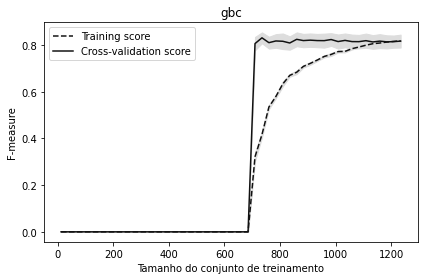

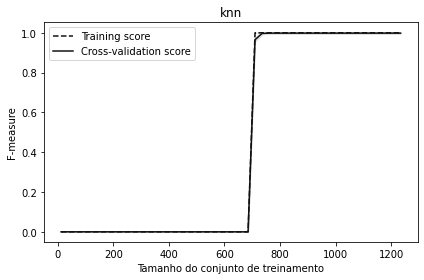

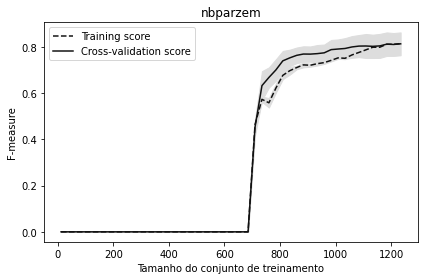

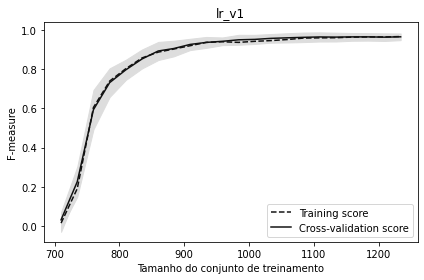

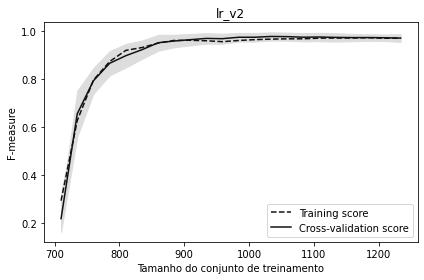

In [52]:
models = [('gbc', gbc), ('knn', knn), ('nbparzem', nbparzem), ('lr_v1', lr_v1), ('lr_v2', lr_v2)]
for name, model in models:
  if name != 'lr_v2':
    plot_learning_curve(X, y, model, name)
  else:
    plot_learning_curve(newX, y, model, name)
plt.close('all')


## Alguns plots para visualizar as métricas

In [35]:
# Defining a function for a custom barplot:
def my_barplot(bars_dct, title):
    # set width of bar
    barWidth = 0.15

    # set height of bar
    bars_gbc = bars_dct['GBC']
    bars_knn = bars_dct['KNN']
    bars_nbparzen = bars_dct['NBParzen']
    bars_lr_v1 = bars_dct['LR_V1']
    bars_lr_v2 = bars_dct['LR_V2']
    bars_ens = bars_dct['Ensemble']

    # Set position of bar on X axis
    r1 = np.arange(len(bars_gbc))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    r5 = [x + barWidth for x in r4]
    r6 = [x + barWidth for x in r5]

    # Make the plot
    plt.bar(r1, bars_gbc, width=barWidth, edgecolor='white', label='GBC')
    plt.bar(r2, bars_knn, width=barWidth, edgecolor='white', label='KNN')
    plt.bar(r3, bars_nbparzen, width=barWidth, edgecolor='white', label='NBParzen')
    plt.bar(r4, bars_lr_v1, width=barWidth, edgecolor='white', label='LR_V1')
    plt.bar(r5, bars_lr_v2, width=barWidth, edgecolor='white', label='LR_V2')
    plt.bar(r6, bars_ens, width=barWidth, edgecolor='white', label='Ensemble')

    # Size, titles and labels
    #plt.figure(num=None, figsize=(18, 9), dpi=100, facecolor='w', edgecolor='k')
    plt.title(title, size=22)
    plt.xlabel('Métrica', fontsize=20)
    plt.ylabel('Média', fontsize=20)

    # Add xticks on the middle of the group bars
    plt.xticks([r + 2.5*barWidth for r in range(len(bars_gbc))], ['Erro', 'Precisão', 'Cobertura', 'F-measure'])

    # Create legend & Show graphic
    plt.subplots_adjust(bottom=-0.0, top=1.5, right=2)
    plt.legend()
    plt.show()



In [36]:
plt.style.use('seaborn-whitegrid')
bars_dict = {'GBC':[], 'KNN': [], 
             'NBParzen': [], 'LR_V1': [], 
             'LR_V2': [], 'Ensemble': []}
results_dict = {}
results_dict['GBC'] = calculate_metrics(cv_results_gbc)
results_dict['KNN'] = calculate_metrics(cv_results_knn)
results_dict['NBParzen'] = calculate_metrics(cv_results_nbparzem)
results_dict['LR_V1'] = calculate_metrics(cv_results_lr_v1)
results_dict['LR_V2'] = calculate_metrics(cv_results_lr_v2)
results_dict['Ensemble'] = calculate_metrics(cv_results_ensemble)

for model_name in results_dict:
  for metric_name in results_dict[model_name]:
    metric = results_dict[model_name][metric_name]
    bars_dict[model_name].append(metric['mean'])

In [37]:
#bars_dict

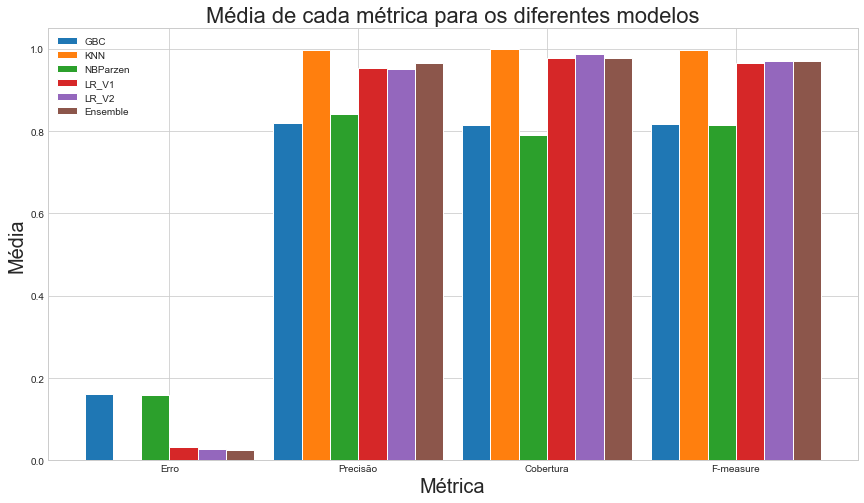

In [38]:
my_barplot(bars_dict, 'Média de cada métrica para os diferentes modelos')

## Teste de Friedman

In [50]:
from scipy.stats import friedmanchisquare

#### Função que realiza o teste, dada uma métrica.

In [58]:
#!pip install scikit_posthocs
def test_significance(metric_name):
  group_gbc = cv_results_gbc[metric_name]
  group_knn = cv_results_knn[metric_name]
  group_parzem = cv_results_nbparzem[metric_name]
  group_lr_v1 = cv_results_lr_v1[metric_name]
  group_lr_v2 = cv_results_lr_v2[metric_name]
  group_ensemble = cv_results_ensemble[metric_name]

  cols = ['x1','x2', 'x3', 'x4', 'x5', 'x6']
  data = [group_gbc, group_knn, group_parzem, group_lr_v1, group_lr_v2, group_ensemble]
  print(data)
  stat, p = friedmanchisquare(*data)
  print('Friedman=%.3f, p=%.3f' % (stat, p))
  #Interpretação dos resultados
  alpha = 0.05 #nível de significância
  if p > alpha:
    print("Não há diferença significativa no desempenho dos classsificadores")
  else:
    print("Há diferença significativa (rejeita H0) no desempenho dos classsificadores")

  #If the null-hypothesis is rejected, we can proceed with a post-hoc test.(Artigo)
  #para realmente saber quais dos classificadores são diferentes, 
  #usar o nemenyi post hoc

  import scikit_posthocs as sp
  teste = sp.posthoc_nemenyi(data)
  print(teste)
  def plot(scores): #fica melhor a visualização para apresentação
    #Pretty plot of significance
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.1', 'square': True,
                     'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
    sp.sign_plot(scores, **heatmap_args)
    plot(teste)

#### Comparando a métrica Accuracy

In [59]:
test_significance('test_accuracy')

[array([0.84057971, 0.85507246, 0.80291971, 0.81021898, 0.82481752,
       0.83211679, 0.86131387, 0.86861314, 0.86861314, 0.81751825]), array([1.        , 1.        , 1.        , 1.        , 0.99270073,
       1.        , 1.        , 1.        , 1.        , 0.99270073]), array([0.85507246, 0.86956522, 0.7810219 , 0.83211679, 0.80291971,
       0.80291971, 0.88321168, 0.88321168, 0.89051095, 0.81021898]), array([0.97826087, 0.97826087, 0.94890511, 0.97810219, 0.94160584,
       0.96350365, 0.97810219, 0.98540146, 0.98540146, 0.94890511]), array([0.98550725, 0.97826087, 0.94890511, 0.97810219, 0.94160584,
       0.97080292, 0.98540146, 0.98540146, 0.98540146, 0.96350365]), [0.9782608695652174, 0.9782608695652174, 0.9635036496350365, 0.9854014598540146, 0.9343065693430657, 0.9781021897810219, 0.9927007299270073, 0.9854014598540146, 0.9854014598540146, 0.9635036496350365]]
Friedman=45.886, p=0.000
Há diferença significativa (rejeita H0) no desempenho dos classsificadores
          1      

#### Comparando a métrica Precision

Friedman=46.084, p=0.000
Há diferença significativa (rejeita H0) no desempenho dos classsificadores
          1         2         3         4         5         6
1  1.000000  0.000002  0.999088  0.082416  0.045757  0.007197
2  0.000002  1.000000  0.000021  0.188514  0.285497  0.623670
3  0.999088  0.000021  1.000000  0.209802  0.131828  0.028587
4  0.082416  0.188514  0.209802  1.000000  0.999960  0.980599
5  0.045757  0.285497  0.131828  0.999960  1.000000  0.995636
6  0.007197  0.623670  0.028587  0.980599  0.995636  1.000000
     1    2    3    4    5    6
1 -1.0  1.0  0.0  0.0  3.0  2.0
2  1.0 -1.0  1.0  0.0  0.0  0.0
3  0.0  1.0 -1.0  0.0  0.0  3.0
4  0.0  0.0  0.0 -1.0  0.0  0.0
5  3.0  0.0  0.0  0.0 -1.0  0.0
6  2.0  0.0  3.0  0.0  0.0 -1.0
-----------


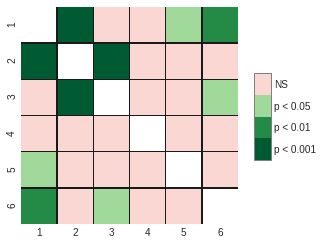

In [ ]:
test_significance('test_precision')

#### Comparando a métrica Recall

Friedman=45.266, p=0.000
Há diferença significativa (rejeita H0) no desempenho dos classsificadores
          1         2         3         4         5         6
1  1.000000  0.000097  0.999999  0.064036  0.005996  0.064036
2  0.000097  1.000000  0.000056  0.634212  0.955511  0.634212
3  0.999999  0.000056  1.000000  0.047452  0.003983  0.047452
4  0.064036  0.634212  0.047452  1.000000  0.985249  1.000000
5  0.005996  0.955511  0.003983  0.985249  1.000000  0.985249
6  0.064036  0.634212  0.047452  1.000000  0.985249  1.000000
     1    2    3    4    5    6
1 -1.0  1.0  0.0  0.0  2.0  0.0
2  1.0 -1.0  1.0  0.0  0.0  0.0
3  0.0  1.0 -1.0  3.0  2.0  3.0
4  0.0  0.0  3.0 -1.0  0.0  0.0
5  2.0  0.0  2.0  0.0 -1.0  0.0
6  0.0  0.0  3.0  0.0  0.0 -1.0
-----------


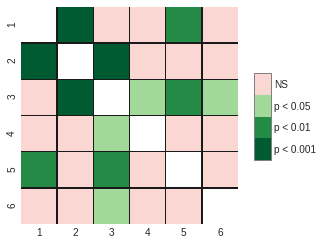

In [ ]:
test_significance('test_recall')

#### Comparando a métrica F1

Friedman=46.108, p=0.000
Há diferença significativa (rejeita H0) no desempenho dos classsificadores
          1         2         3         4         5         6
1  1.000000  0.000003  1.000000  0.124060  0.043205  0.045446
2  0.000003  1.000000  0.000003  0.147540  0.323422  0.314050
3  1.000000  0.000003  1.000000  0.134528  0.047782  0.050218
4  0.124060  0.147540  0.134528  1.000000  0.999154  0.999318
5  0.043205  0.323422  0.047782  0.999154  1.000000  1.000000
6  0.045446  0.314050  0.050218  0.999318  1.000000  1.000000
     1    2    3    4    5    6
1 -1.0  1.0  0.0  0.0  3.0  3.0
2  1.0 -1.0  1.0  0.0  0.0  0.0
3  0.0  1.0 -1.0  0.0  3.0  0.0
4  0.0  0.0  0.0 -1.0  0.0  0.0
5  3.0  0.0  3.0  0.0 -1.0  0.0
6  3.0  0.0  0.0  0.0  0.0 -1.0
-----------


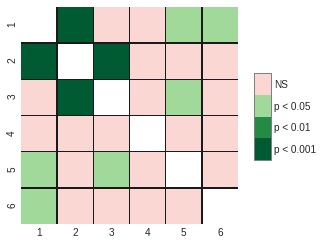

In [ ]:
test_significance('test_f1')